**Grupo 4**



Desarrollo de un modelo predictivo de detección precoz de anemia en infantes menores de 5 años de Perú


Instalamos e importamos las librerías con las cuales trabajaremos:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Cargamos el dataset raw:

In [ ]:
data_raw = pd.read_csv('/content/datosanemia_sin_outliers.csv', sep=";", decimal=",", encoding='latin-1')
data_raw.head()

,Unnamed: 0,X,ï..CASEID,HW1,HW2,HW3,HW53,V101,V102,V103,V104,V106,V113,V119,V122,anemia
0,1,1,1001192.0,41.0,15.9,98.9,NaN,17,2,3,7,1,43,0,0,0
1,2,2,1001212.0,7.0,9.7,69.0,NaN,17,2,3,15,2,43,0,0,1
2,3,3,1001232.0,0.0,4.0,51.6,NaN,17,2,3,1,2,43,0,0,0
3,4,4,1004442.0,49.0,17.1,93.8,NaN,17,2,2,10,1,11,1,0,1
4,5,5,1004487.0,19.0,10.1,78.5,NaN,17,2,3,96,1,97,7,7,0


Modificamos los headers: 

In [ ]:
columns = {
    "HW1": "edad_meses",
    "HW2": "peso_kg",
    "HW3": "altura_cm",
    "HW53": "hemoglobina",
    "V101": "departamento",
    "V102": "tipo_resid",
    "V103": "sitio_resid",
    "V104": "anos_resid",
    "V106": "educ",
    "V113": "agua_potable",
    "V119": "elet",
    "V122": "conserv_alim",
    "ï..CASEID": "CASEID"
}

data_input = pd.DataFrame(data_raw).rename(columns=columns)
data_input.head()

,Unnamed: 0,X,CASEID,edad_meses,peso_kg,altura_cm,hemoglobina,departamento,tipo_resid,sitio_resid,anos_resid,educ,agua_potable,elet,conserv_alim,anemia
0,1,1,1001192.0,41.0,15.9,98.9,NaN,17,2,3,7,1,43,0,0,0
1,2,2,1001212.0,7.0,9.7,69.0,NaN,17,2,3,15,2,43,0,0,1
2,3,3,1001232.0,0.0,4.0,51.6,NaN,17,2,3,1,2,43,0,0,0
3,4,4,1004442.0,49.0,17.1,93.8,NaN,17,2,2,10,1,11,1,0,1
4,5,5,1004487.0,19.0,10.1,78.5,NaN,17,2,3,96,1,97,7,7,0


In [ ]:
data_input = data_input.drop(columns=['hemoglobina'])
data_input.head()

,Unnamed: 0,X,CASEID,edad_meses,peso_kg,altura_cm,departamento,tipo_resid,sitio_resid,anos_resid,educ,agua_potable,elet,conserv_alim,anemia
0,1,1,1001192.0,41.0,15.9,98.9,17,2,3,7,1,43,0,0,0
1,2,2,1001212.0,7.0,9.7,69.0,17,2,3,15,2,43,0,0,1
2,3,3,1001232.0,0.0,4.0,51.6,17,2,3,1,2,43,0,0,0
3,4,4,1004442.0,49.0,17.1,93.8,17,2,2,10,1,11,1,0,1
4,5,5,1004487.0,19.0,10.1,78.5,17,2,3,96,1,97,7,7,0


Dividimos los datasets de revisiones y etiquetas

In [ ]:
x = pd.DataFrame(data_input).drop(columns=["CASEID", "anemia"])
y = data_input["anemia"]

Chequeo para datos desbalanceados

In [ ]:
data_input.anemia.value_counts()

0    139950
1     33615
Name: anemia, dtype: int64

Utilizando SMOTE para balancear dados

In [ ]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Chequeo los datos rebalanceados

In [ ]:
pd.Series(y_smote).value_counts()

1    139950
0    139950
dtype: int64



Dividimos en train y test.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.33, random_state=42)

Haciemos el Tunning del modelo

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 22, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 39.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Entrenamos al modelo Random Forest

In [ ]:
modelo = RandomForestClassifier(bootstrap=rf_random.best_params_["bootstrap"],
                                max_depth=rf_random.best_params_["max_depth"],
                                max_features=rf_random.best_params_["max_features"],
                                min_samples_leaf=rf_random.best_params_["min_samples_leaf"],
                                min_samples_split=rf_random.best_params_["min_samples_split"],
                                n_estimators=rf_random.best_params_["n_estimators"])

modelo.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Aplicamos la evaluación del modelo

In [ ]:
preds = modelo.predict(x_test)

print("Acurácia do modelo: %.2f" %(accuracy_score(preds, y_test)*100) + "%")
print("Cohen Kappa       : %.2f" %(cohen_kappa_score(preds, y_test)*100) + "%")

Acurácia do modelo: 86.55%
Cohen Kappa       : 73.10%


El modelo tiene una accuracy de 

Confusion Matrix

In [ ]:
confusion_matrix(preds, y_test)

array([[41451,  7899],
       [ 4528, 38489]])

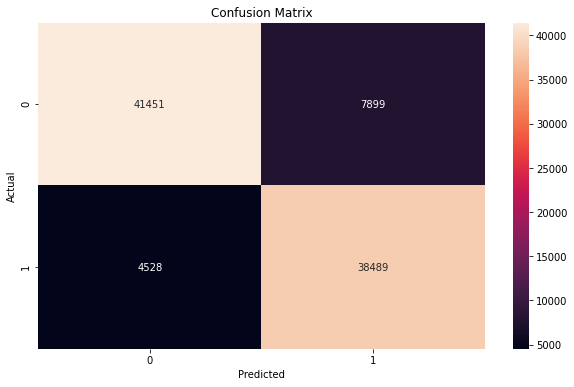

              precision    recall  f1-score   support

           0       0.90      0.84      0.87     49350
           1       0.83      0.89      0.86     43017

    accuracy                           0.87     92367
   macro avg       0.87      0.87      0.87     92367
weighted avg       0.87      0.87      0.87     92367



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(preds, y_test)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(preds, y_test))